# Papers and patents are becoming less disruptive over time

This is the third assignment of the Applied Machine Learning course. In this assignment we will create a Machine Learning model that can predict, as accurate as possible, the [CD5](http://russellfunk.org/cdindex/static/papers/funk_ms_2017.pdf) (measures how likely is a work that cites a scientific paper to cite the works that paper cites) of a published paper without looking into the future work that cites it:

- Park, M., Leahey, E. & Funk, R.J. Papers and patents are becoming less disruptive over time. Nature 613, 138–144 (2023). https://doi.org/10.1038/s41586-022-05543-x

---

> John Papadatos, Undergraduate Student <br>
> Department of Management Science and Technology <br>
> Athens University of Economics and Business <br>
> t8190314@aueb.gr

---

- First of all make sure that the following Python packages are installed.


- If some packages missing you can install them using the following command: <br>
  `pip install <package-name>` or `pip3 install <package-name>`

In [1]:
%%capture

import cld3  # Package name on PyPI: pycld3
import spacy
import sqlite3
import numpy as np
import pandas as pd
import sklearn as sk  # Package name on PyPI: scikit-learn
import tensorflow as tf
import keras_tuner as kt  # Package name on PyPI: keras-tuner
import seaborn as sns
import matplotlib.pyplot as plt

# Load the pre-trained small English language model for NLP
nlp = spacy.load("en_core_web_sm")

# Print the output without scientific notation
pd.options.display.float_format = '{:.3f}'.format

The data that we will use is in the form of an [SQLite](https://www.sqlite.org/index.html) database. It is derived from the [alexandria3k package](https://github.com/dspinellis/alexandria3k) written by [Professor Diomidis Spinellis](https://www2.dmst.aueb.gr/dds/). In particular, the data comprises part of the [publications graph](https://dspinellis.github.io/alexandria3k/cli-eg.html#publications-graph) for a 1% sample of all CrossRef available publications that have abstracts; an additional table in the database contains the CD5 index for papers.

Below you can the the schema of the SQLite database:

![schema](https://mermaid.ink/img/pako:eNqNU01vgzAM_SvI57barpx33mXXSMgkZmQNSZUYbajiv4_PJXQgNRfs54djPzt3kE4R5CANhvCm8dNjI2w2nAnJvp2_huw-Q-PRKtqs2VB0sQzsUXJElNPRubWl0aEmVSjs9uDGWa73Ah2hn_F-_sxVCXgVkJ3Po3G5vA_2iBfYcu18OGC-JExPFXmykp4hh7b8IslH1NGQSltFP4_6rRVFGaOIUzy6zsvVSVr9S_C_4zlSYFVpo5G1syG9fiecDnMJpzO12NCmgKSPqFdM8tAAetbSULFZjWQNdkeZJn5S0nUah4Uc9LHkS0XYLOnmvh5O0JBvUKvhiUy_COCahsyQD6ZCfxUg7MgbpHQfnZWQs2_pBO1NIdPyoiCv0ATqfwEJUA3E?type=png)

- SQLite is a serverless file-based database engine that reads and writes data directly to disk files.
- In SQLite, a database is typically stored in a single file, which contains all the tables, indices, views, triggers, and other objects that make up the database.
- In our case, the database file is called `publications_graph.db`. 
- We will use the `sqlite3` module to establish a connection with the `publications_graph.db` database.

In [2]:
conn = sqlite3.connect("data/publications_graph.db")

- We will use the `read_sql()` method to read the necessary columns from the `works` table into a DataFrame, which is stored in the `works` variable.
- We will not need the `published_day` and `published_month` columns. The Nature paper suggests that the CD5 is decreasing over time, but does not suggest that there are specific months or days that are more important than others. Thus, including only the year as feature should be sufficient for capturing the overall trend.

In [3]:
works = pd.read_sql("SELECT id, title, abstract, published_year AS year, doi FROM works", conn)
print('Number of works records:', format(len(works), ",d").replace(",", "."), end='\n\n')
works.sample(5)

Number of works records: 149.078



,id,title,abstract,year,doi
44045,1345286,Research beyond biomedical confines: towards b...,<jats:p>‘Working Together to Prevent Suicide’ ...,2019.000,10.31117/neuroscirn.v2i4.43
99967,3099568,Influencia de expectativas educativas y relaci...,<jats:p>El Embarazo en la Adolescencia (EA) es...,2020.000,10.15174/au.2020.2562
12469,279423,Configuración de la Agenda en la Unión Europea,<jats:p>&lt;p&gt;El establecimiento de la agen...,2016.000,10.18543/ced-55-2016pp33-59
143525,4229244,Case-control study of ADARB1 and ADARB2 gene v...,<jats:title>Abstract</jats:title>\n <...,2015.000,10.1186/s10194-015-0511-y
122536,3622891,MEDIASI INTEREST BASED DALAM PENYELESAIAN SENG...,<jats:p>Meningkatnya perkara tanah di pengadil...,2016.000,10.24843/kp.2016.v38.i02.p05


- We will use the `info()` method to get an overview of the DataFrame and ensure that the datatypes are correct.

In [4]:
works.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149078 entries, 0 to 149077
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        149078 non-null  int64  
 1   title     149078 non-null  object 
 2   abstract  149078 non-null  object 
 3   year      147323 non-null  float64
 4   doi       149078 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 5.7+ MB


- We will use the `describe()` method to check some decriptive statistics for the `year` column.

In [5]:
works.year.describe()

count   147323.000
mean      2011.979
std         12.842
min       1876.000
25%       2009.000
50%       2017.000
75%       2020.000
max       2121.000
Name: year, dtype: float64

- Besides the maximum value that is invalid, we can observe that 75% of the papers in our dataset are published after 2009, while the Nature paper uses papers that were published until 2010.
- We can also notice that there are some recent years for which the cdindex is not CD5, since those papers have not been published for 5 years or more. We will handle those later.

- We will check whether sufficient amount of data are present for each feature, to be able to use it in our model.

In [6]:
pd.concat([works.isna().sum(), works.isna().mean()],
          axis=1, keys=['missing_count', 'missing_ratio'])

,missing_count,missing_ratio
id,0,0.000
title,0,0.000
abstract,0,0.000
year,1755,0.012
doi,0,0.000


- We will use the `read_sql()` method to read the columns from the `work_references` table into a DataFrame, which is stored in the `work_references` variable.

In [7]:
work_references = pd.read_sql("SELECT work_id, article_title, doi, year FROM work_references", conn)
print('Number of work_references records:', format(len(work_references), ",d").replace(",", "."), end='\n\n')
work_references.sample(5)

Number of work_references records: 2.852.181



,work_id,article_title,doi,year
392725,591927,None,None,None
2688176,4161736,Coordinated regulation of cholinergic motor ne...,10.1038/nn.2989,2011
231826,312094,A guideline for the preparation of species des...,10.1111/j.1365-2761.1989.tb00287.x,1989
448577,738941,None,10.1371/journal.pgen.0010056,None
1133385,2064688,None,None,None


- We will use the `info()` method to get an overview of the DataFrame and ensure that the datatypes are correct.

In [8]:
work_references.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2852181 entries, 0 to 2852180
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   work_id        int64 
 1   article_title  object
 2   doi            object
 3   year           object
dtypes: int64(1), object(3)
memory usage: 87.0+ MB


- We can see that the dtype of the `year` column is object (contains a mixture of data types, such as strings, numbers, and other Python objects).
- After inspecting the non-numeric years I noticed some particular patterns:
  - `'YYYYa'`, `'YYYYb'`, `'YYYYc'`, `'YYYYd'` => Probably refering to quarters
  - `'YYYY,'`, `'YYYY;'`, `'YYYY:'`, `'(YYYY)'`
- We will replace the letters `'a'`, `'b'`, `'c'`, `'d'` and the symbols `','`, `';'`, `':'`, `'('`, `')'` with the empty string `''`.

In [9]:
work_references.year = work_references.year.str.replace(r'a|b|c|d|,|;|:|\(|\)', '', regex=True)

- We will convert the `year` column to numeric data type, with the rest of the non-numeric years being converted to `NaN`.

In [10]:
work_references.year = pd.to_numeric(work_references.year, errors='coerce')
work_references.year.dtype

dtype('float64')

- We will use the `describe()` method to check some decriptive statistics for the `year` column.

In [11]:
work_references.year.describe()

count    1264709.000
mean        2581.063
std       107108.347
min            0.000
25%         1998.000
50%         2008.000
75%         2014.000
max     20202020.000
Name: year, dtype: float64

- Besides the minimum and maximum values that are invalid, we can observe that the papers referenced are older compared to the papers themselves.

- We will check whether sufficient amount of data are present for each feature, to be able to use it in our model.

In [12]:
pd.concat([work_references.isna().sum(), work_references.isna().mean()],
          axis=1, keys=['missing_count', 'missing_ratio'])

,missing_count,missing_ratio
work_id,0,0.000
article_title,2311266,0.810
doi,744220,0.261
year,1587472,0.557


- In general, if some features have a very large percentage of missing data (e.g. more than 50%), it may be difficult to impute these values accurately and it is considered better to drop them.
- We will drop the `article_title` column.
- We will keep the `year` column for now, because we still need it for the preprocessing.

In [13]:
work_references = work_references.drop(columns=['article_title'])

- We will use the `read_sql()` method to read the necessary columns from the `work_authors` table into a DataFrame, which is stored in the `work_authors` variable.

In [14]:
work_authors = pd.read_sql("SELECT id, work_id FROM work_authors", conn)
print('Number of work_authors records:', format(len(work_authors), ",d").replace(",", "."), end='\n\n')
work_authors.sample(5)

Number of work_authors records: 577.214



,id,work_id
164058,22024994818,1344299
200109,29013311493,1770832
354834,48644833280,2969045
188228,25775243267,1573196
422439,53767078035,3281682


- We will check for missing values.

In [15]:
pd.concat([work_authors.isna().sum(), work_authors.isna().mean()],
          axis=1, keys=['missing_count', 'missing_ratio'])

,missing_count,missing_ratio
id,0,0.000
work_id,0,0.000


- We will use the `read_sql()` method to read the columns from the `author_affiliations` table into a DataFrame, which is stored in the `author_affiliations` variable.

In [16]:
author_affiliations = pd.read_sql("SELECT author_id, name FROM author_affiliations", conn)
print('Number of author_affiliations records:', format(len(author_affiliations), ",d").replace(",", "."), end='\n\n')
author_affiliations.sample(5)

Number of author_affiliations records: 327.646



,author_id,name
101148,17994694661,Department of Surgical and Biomedical Sciences...
75286,12399017984,"Department of Computer Science, Hong Kong Bapt..."
11165,2689646597,Department of Nuclear Science and Engineering ...
191791,41661251591,College of Environment and Safety Engineering
77987,12676939785,"Boston University Medical Center, Boston, Mass..."


- We will check for missing values.

In [17]:
pd.concat([author_affiliations.isna().sum(), author_affiliations.isna().mean()],
          axis=1, keys=['missing_count', 'missing_ratio'])

,missing_count,missing_ratio
author_id,0,0.000
name,8,0.000


- It looks like there are not any missing values, however, as you can see below there are actually a lot of affiliations missing.

In [18]:
join = pd.merge(work_authors, author_affiliations, left_on='id', right_on='author_id', how='left')
pd.concat([join[['author_id', 'name']].isna().sum(), join[['author_id', 'name']].isna().mean()],
          axis=1, keys=['missing_count', 'missing_ratio'])

,missing_count,missing_ratio
author_id,321452,0.495
name,321460,0.495


- We will use the `read_sql()` method to read the columns from the `work_subjects` table into a DataFrame, which is stored in the `work_subjects` variable.

In [19]:
work_subjects = pd.read_sql("SELECT work_id, name FROM work_subjects", conn)
print('Number of work_subjects records:', format(len(work_subjects), ",d").replace(",", "."), end='\n\n')
work_subjects.sample(5)

Number of work_subjects records: 234.357



,work_id,name
217371,4064161,Health Professions (miscellaneous)
71841,1117296,Ecology
224198,4165351,Clinical Psychology
156395,2983302,Organic Chemistry
192610,3622108,General Materials Science


- We will check whether sufficient amount of data are present for each feature, to be able to use it in our model.

In [20]:
pd.concat([work_subjects.isna().sum(), work_subjects.isna().mean()],
          axis=1, keys=['missing_count', 'missing_ratio'])

,missing_count,missing_ratio
work_id,0,0.000
name,0,0.000


- As you can see below there are ~116 million rows in the `cdindex` table, while there are only ~3 million rows in `works` and `work_references` tables combined.

In [21]:
count = pd.read_sql("SELECT COUNT(*) FROM cdindex", conn)
print('Number of cdindex records:', format(count.values[0, 0], ",d").replace(",", "."))

Number of cdindex records: 116.568.934


- There is no reason to read all those data in memory.
- We will create a table named `cd5` that will contain the CD5 indexes for the papers contained in either `works` or `work_references`.

In [22]:
cursor = conn.cursor()
cursor.execute("""
CREATE TABLE IF NOT EXISTS cd5 AS
SELECT doi, cdindex
FROM cdindex
WHERE doi IN (SELECT doi FROM works) OR doi IN (SELECT doi FROM work_references)
""")
conn.commit()

- We will use the `read_sql()` method to read the columns from the `cd5` table into a DataFrame, which is stored in the `cd5` variable.

In [23]:
cd5 = pd.read_sql("SELECT doi, cdindex FROM cd5", conn)
print('Number of cd5 records:', format(len(cd5), ",d").replace(",", "."), end='\n\n')
cd5.sample(5)

Number of cd5 records: 1.876.551



,doi,cdindex
258762,10.1002/(sici)1099-0771(199912)12:4<275::aid-b...,-0.056
76005,10.3390/educsci5010010,0.041
1670505,10.3923/jest.2012.460.474,1.000
1226869,10.1016/s1470-2045(06)70938-x,-0.008
1856540,10.1128/iai.00678-15,-0.004


- We will use the `info()` method to get an overview of the DataFrame and ensure that the datatypes are correct.

In [24]:
cd5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1876551 entries, 0 to 1876550
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   doi      object 
 1   cdindex  float64
dtypes: float64(1), object(1)
memory usage: 28.6+ MB


- We will check for missing values.

In [25]:
pd.concat([cd5.isna().sum(), cd5.isna().mean()],
          axis=1, keys=['missing_count', 'missing_ratio'])

,missing_count,missing_ratio
doi,0,0.000
cdindex,89891,0.048


- Since this is the target variable we will have to drop the missing values, because imputation will introduce bias to the model.

In [26]:
cd5 = cd5.dropna()

- Our task is to predict the CD5. 
- The CD5 is the CD index calculated over a time window of 5 years.
- Due to the lack of data, however, I decided to also allow CD4 in the dataset assuming that it must be a pretty good proxy to the CD5 values, which indeed is supported by the data as we will see afterwards.
- Furthermore, the `doi` column is included to remove duplicates, since some papers are present in both `works` and `work_references` and also the same paper can be referenced by more than one other paper.

In [27]:
works_cdindex = pd.merge(works, cd5, on='doi')
work_references_cdindex = pd.merge(work_references, cd5, on='doi')
cdindexes = pd.concat([works_cdindex[['doi', 'year', 'cdindex']],
                       work_references_cdindex[['doi', 'year', 'cdindex']]], axis=0)
cdindexes = cdindexes[~cdindexes.doi.duplicated()]
cdindexes = cdindexes.dropna()
cdindexes

,doi,year,cdindex
0,10.1017/s1473550406002904,2007.000,0.000
1,10.1144/gsl.eng.1986.003.01.02,1986.000,0.000
2,10.1152/ajplung.00203.2007,2007.000,-0.003
3,10.1634/stemcells.2007-0216,2007.000,-0.004
4,10.3139/146.101520,2007.000,-0.004
...,...,...,...
2051377,10.1080/09668139108411954,1991.000,0.188
2051378,10.1007/bf02707703,1993.000,-0.003
2051379,10.1006/jcec.1995.1015,1995.000,1.000
2051380,10.1017/s0143814x00008540,1997.000,0.000


- We will compare the distributions of CD2, CD3 and CD4 with the distribution of CD5 for the 3 most recent years for which the CD5 can be computed.

In [28]:
from datetime import datetime as dt

cdindexes_cd5 = cdindexes[(cdindexes.year >= dt.now().year - 7) & (cdindexes.year <= dt.now().year - 5)]
cdindexes_cd4 = cdindexes[cdindexes.year == dt.now().year - 4]
cdindexes_cd3 = cdindexes[cdindexes.year == dt.now().year - 3]
cdindexes_cd2 = cdindexes[cdindexes.year == dt.now().year - 2]

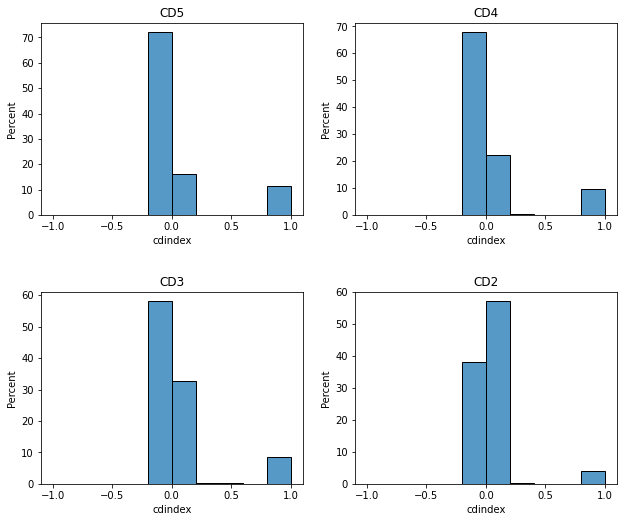

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
fig.subplots_adjust(wspace=0.2, hspace=0.4, left=0.1, right=0.9, top=0.9, bottom=0.1)

axs[0, 0].set_title('CD5')
sns.histplot(cdindexes_cd5.cdindex, bins=10, stat='percent', ax=axs[0, 0])

axs[0, 1].set_title('CD4')
sns.histplot(cdindexes_cd4.cdindex, bins=10, stat='percent', ax=axs[0, 1])

axs[1, 0].set_title('CD3')
sns.histplot(cdindexes_cd3.cdindex, bins=10, stat='percent', ax=axs[1, 0])

axs[1, 1].set_title('CD2')
sns.histplot(cdindexes_cd2.cdindex, bins=10, stat='percent', ax=axs[1, 1])

plt.show()

- As you can see the distribution of CD4 is pretty similar to the distribution of CD5, so we will keep CD4 as well.

In [30]:
cdindexes = cdindexes[(cdindexes.year >= 1950) & (cdindexes.year <= dt.now().year - 4)]

- From now on I will refer to both CD4 and CD5 as CD5.
- Let's create a histogram of CD5 to check its overall distribution.

<AxesSubplot:xlabel='cdindex', ylabel='Percent'>

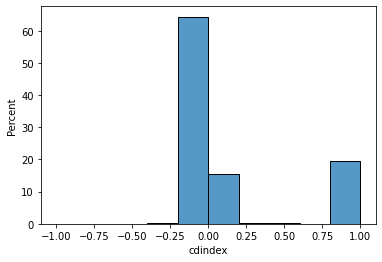

In [31]:
sns.histplot(cdindexes.cdindex, bins=10, stat='percent')

- The distribution of CD5 in our sample is significantly different than the distribution of CD5 presented in the [Extended Data Fig. 1](https://www.nature.com/articles/s41586-022-05543-x/figures/7) of the Nature paper (which is based on a larger dataset).

- The distribution of CD5 in our sample more closely resembles with what we can see in [Fig. 5](https://www.nature.com/articles/s41586-022-05543-x/figures/5) of the Nature paper, where the majority of the points are between `[-0.2, 0.2]` and some points exactly at `1`.

- The [Fig. 5](https://www.nature.com/articles/s41586-022-05543-x/figures/5) contains papers published in premier publication venues (indicating high-quality work), which is an indication that our sample may be biased.

- The best solution to prevent overfitting is to use complete training data. The dataset should cover the full range of inputs that the model is expected to handle. A model trained on more complete data will naturally generalize better. 

- The models that we will train later using this dataset will make a poor job predicting the CD5 of papers in general, since they will learn to either predict values close to 0 or 1.

- Let's also create a plot to display the average CD5 per year.

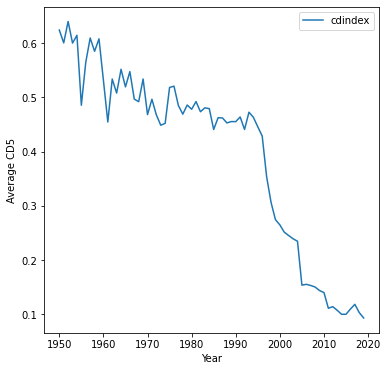

In [32]:
cdindexes.groupby('year').agg({'cdindex': 'mean'}).plot(figsize=(6, 6))
plt.ylabel('Average CD5')
plt.xlabel('Year')
plt.show()

- We can see that as an overall trend, the CD5 is decreasing, however, the average CD5 in our sample is consistently higher compared to [Fig. 2](https://www.nature.com/articles/s41586-022-05543-x/figures/2) of the Nature paper.

- We will now use our findings to filter the `works` and `work_references`.

In [33]:
works = works[(works.doi.isin(cd5.doi)) & (works.year >= 1950) & (works.year <= dt.now().year - 4)]
work_references = work_references[((work_references.year >= 1950) & (work_references.year <= dt.now().year - 4))
                                  | (work_references.year.isna())]

- We can finally now drop the `year` column from `work_references`.

In [34]:
work_references = work_references.drop(columns=['year'])

- Let's now proceed with the preprocessing of the text-based features, namely `title` and `abstract`.
- First of all, we will have to check if there are any papers not written in English.
- We can use the `get_language()` function from the `cld3` package to detect the language of a text.
- The `get_language()` function is not designed to handle arrays directly, so we will use the `vectorize()` function from the `NumPy` package to create a new function that can be used to apply the `get_language()` function to each element of an array.

In [35]:
%%capture --no-stdout

get_lang_vect = np.vectorize(cld3.get_language)

total_works = len(works)
works = works[get_lang_vect(works.abstract)[0] == 'en']
english_works = len(works)
print('Percentage of papers written in English:', english_works / total_works)

Percentage of papers written in English: 0.9476539900962592


- Since the vast majority of the papers are written in English we can simply ignore the rest.

- The `text_preprocessor()` function receives a text as input and performs the following operations:
  - Converts the text to lowercase
  - Removes the XML tags
  - Removes the stop words (based on the default spaCy list)
  - Removes punctuation
  - Removes numbers
  - Removes tokens with less than 3 characters
  - Lemmatizes the words

In [36]:
import re

def text_preprocessor(text):
    text = text.lower()
    text = re.sub("<[a-zA-Z:/]+>", " ", text)

    doc = nlp(text)
    no_stop_words = [token.lemma_ for token in doc
                     if not token.is_stop and not token.is_punct
                     and not token.like_num and len(token.text) >= 3]
    return ' '.join(no_stop_words)

- We will combine the `title` and `abstract` into a single `text` feature by concatenating them.
- We will create a new `text` column in the `works` DataFrame that will contain the clean text (high information density words) for each paper.

In [37]:
text = works.title + ' ' + works.abstract
works['text'] = text.apply(text_preprocessor)
works.sample(3)

,id,title,abstract,year,doi,text
116883,3478261,A Generalized MILP Formulation for the Period-...,<jats:p>We study a resource leveling problem w...,2019.000,10.3390/a13010006,generalize milp formulation period aggregated ...
143099,4180201,Waterbirds from wetlands of the southeast of t...,<jats:p>We present a waterbird inventory corre...,2011.000,10.15560/7.4.537,waterbird wetland southeast córdoba province a...
74612,2507507,Water Uptake in PEMFC Catalyst Layers,<jats:p>Water uptake profiles of proton-exchan...,2011.000,10.1149/1.3635598,water uptake pemfc catalyst layer water uptake...


- We can now drop the `title` and `abstract` columns from `works`.

In [38]:
works = works.drop(columns=['title', 'abstract'])

- Let's now proceed with the feature engineering.
- Since we only have a small subset of the total published papers, we cannot compute metrics such as averages and standard deviations of the CD5 for authors, affiliations, and subjects. (If we could, we would compute those for each paper only based on previously published work to avoid overfitting).

- The authors of the Nature paper mention that disruptive papers are more likely to introduce new words/pairs of words.
- For that reason, I wanted to compute for each paper the number of new words introduced compared to its references and normalize it by the number of words in the paper's abstract and the total number of unique words in the abstracts of its referenced papers, to be comparable.
- Unfortunately, while I downloaded the [alexandria3k package](https://github.com/dspinellis/alexandria3k) and the Crossref data as noted in the documentation, when I tried to populate an SQLite database with the abstracts of the papers included in `work_references` using the following code, I realized that it would require more time than I have available.

```python
from alexandria3k.crossref import Crossref

crossref_instance = Crossref('April 2022 Public Data File from Crossref')

crossref_instance.populate(
    "reference_abstracts.db",
    columns=[
        "works.doi",
        "works.abstract",
    ],
    condition="works.doi IN (SELECT DISTINCT doi FROM attached.work_references)",
    attach_databases=["attached:publications_graph.db"]
)
```

- For completeness, I want to mention that I also tried the EXISTS operator but it was even slower.

- The authors of the Nature paper also mention that disruptive papers tend to contain more verbs evoking creation and discovery while consolidating papers tend to use more verbs evoking improvement and application.
- For that reason, I will count for each paper the number of disruptive and consolidating words and then I will compute their ratio. The set of disruptive words consists of the most popular verbs evoking creation and discovery, while the set of consolidating words consists of the most popular verbs evoking improvement and application for more robust results.

In [39]:
disruptive_words = {
    'create', 'make', 'build', 'construct', 'form', 'develop', 'invent', 'craft',
    'generate', 'discover', 'identify', 'spot', 'detect', 'find', 'determine'
}

consolidating_words = {
    'improve', 'enhance', 'increase', 'boost', 'upgrade', 'refine', 'evolve',
    'optimize', 'reform', 'apply', 'use', 'utilize', 'employ', 'harness'
}

def disruptive_to_consolidating_ratio(text):
    words = text.split()

    disruptive_count = 0
    consolidating_count = 0
    for word in words:
        if word in disruptive_words:
            disruptive_count += 1
        elif word in consolidating_words:
            consolidating_count += 1

    return (disruptive_count + 1) / (consolidating_count + 1)

In [40]:
works['disruptive_to_consolidating_ratio'] = works.text.apply(disruptive_to_consolidating_ratio)

- From the `work_references` DataFrame we can obtain:
  - The number of references for each paper

In [41]:
join = pd.merge(works, work_references, left_on='id', right_on='work_id', suffixes=('_work', '_ref'), how='left')
num_of_references = join.groupby('id').size().to_frame('num_of_references')
num_of_references['num_of_references'] = num_of_references['num_of_references'].replace(1, 0)
num_of_references

,num_of_references
id,
171,23
239,5
284,59
299,66
373,25
...,...
4477724,23
4489260,40
4490759,23


- From the `work_authors` DataFrame we can obtain:
  - The number of authors for each paper 

In [42]:
join = pd.merge(works, work_authors, left_on='id', right_on='work_id', suffixes=('_work', '_author'), how='left')
num_of_authors = join.groupby('id_work').size().to_frame('num_of_authors')
num_of_authors.value_counts()

num_of_authors
2                 11349
1                 10375
3                 10002
4                  7503
5                  5536
                  ...  
42                    1
53                    1
52                    1
51                    1
2934                  1
Length: 73, dtype: int64

- From the `work_subjects` DataFrame we can obtain:
  - The number of subjects each paper is about

In [43]:
join = pd.merge(works, work_subjects, left_on='id', right_on='work_id', how='left')
num_of_subjects = join.groupby('id').size().to_frame('num_of_subjects')
num_of_subjects

,num_of_subjects
id,
171,4
239,1
284,4
299,3
373,4
...,...
4477724,1
4489260,3
4490759,1


- We will combine the features created above into a single dataset.

In [44]:
input = pd.merge(works[['id', 'doi', 'year', 'disruptive_to_consolidating_ratio']],
                 num_of_references, left_on='id', right_index=True)
input = pd.merge(input, num_of_authors, left_on='id', right_index=True)
input = pd.merge(input, num_of_subjects, left_on='id', right_index=True)
input = pd.merge(input, cd5, on='doi')
input = input.drop(columns=['id', 'doi'])
input

,year,disruptive_to_consolidating_ratio,num_of_references,num_of_authors,num_of_subjects,cdindex
0,2007.000,3.000,23,1,4,0.000
1,1986.000,1.000,5,1,1,0.000
2,2007.000,0.400,59,4,4,-0.003
3,2007.000,7.000,66,8,3,-0.004
4,2007.000,1.000,25,3,4,-0.004
...,...,...,...,...,...,...
57981,2013.000,2.000,23,1,1,-0.100
57982,1998.000,0.167,40,3,3,-0.008
57983,2001.000,2.000,23,2,1,-0.040
57984,2000.000,0.500,26,1,2,0.100


- We will separate the features from the target variable.

In [45]:
X = input.drop(columns=['cdindex'])
y = input['cdindex']

- As our first regression model, we will employ `DecisionTreeRegressor` because it is easily interpretable, it can model many kinds of relationships, it is less sensitive to outliers compared to other regression models and it does not require standardization.

- We will use the Mean Absolute Error (MAE) to evaluate our model:

$$ \mathrm {MAE} ={\frac {\sum _{i=1}^{n}\left|y_{i}-\hat{y}_{i}\right|}{n}}$$

- Let's now proceed with the feature selection.
- Since we only have five features and a relatively small dataset, we can simply try every possible combination of features and select the best one.

- First, we will create a list of all possible combinations of features.

In [46]:
from itertools import combinations

feature_combinations = []
for k in range(1, len(X.columns) + 1):
    feature_combinations += list(combinations(X.columns, k))

- Then, we will loop over every feature combination and we will select the best one using cross-validation.
- We will also use the `GridSearchCV` class to find the optimal value for the `max_depth` hyperparameter for every feature combination, which is used to prevent the model from overfitting.

In [47]:
param_grid =  {
    'max_depth': [depth for depth in range(1, 11)]
}

In [48]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV


best_score, best_features, best_model = float('inf'), None, None

for features in feature_combinations:
    X_selected = X[list(features)]

    model = DecisionTreeRegressor()
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error')
    grid_search.fit(X_selected, y)

    score = -1 * grid_search.best_score_

    if score < best_score:
        best_score = score
        best_features = features
        best_model = grid_search.best_estimator_

print("Best combination of features:", best_features)
print("Best score:", best_score)

Best combination of features: ('year', 'num_of_references')
Best score: 0.04031583656286129


- To assess our model's performance, we can compare its mean absolute error (MAE) to the standard deviation of the target variable. This can help us understand how well our model's predictions are performing relative to the variability of the actual target variable.

In [49]:
print("The standard deviation of the target variable is:", y.std())

The standard deviation of the target variable is: 0.44563919830019544


- As you can see the mean absolute error (MAE) is significantly lower than the standard deviation, which suggests that the model is capturing the variations in the target variable quite well, and the predicted values are close to the actual values.

- Now lets check the feature importances.

<AxesSubplot:xlabel='feature', ylabel='importance'>

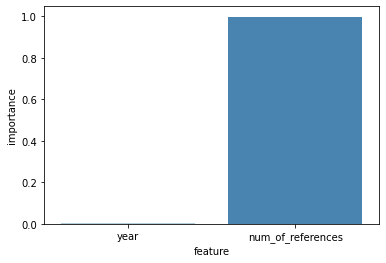

In [50]:
feature_importances = best_model.feature_importances_
feature_importances_df = pd.DataFrame({'feature': X[list(best_features)].columns,
                                       'importance': feature_importances})
sns.barplot(x='feature', y='importance', data=feature_importances_df, palette='Blues')

- What did our model actually learned?
- As we mentioned in the beginning, the CD5 index measures how likely is a work that cites a scientific paper to also cite the works that paper cites. Thus, papers without any references will always have a CD5 index equal to 1.
- Let's build a dummy regressor that will always predict CD5 index equal to 1 when the number of references is equal to 0 and CD5 index equal to 0 otherwise.

In [51]:
def dummy_regressor(num_of_references):
    if num_of_references == 0:
        return 1
    else:
        return 0

In [52]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y, X.num_of_references.apply(dummy_regressor)))

0.028853496560947402


- We can see that the dummy regressor is performing better than our model.

- For completeness, I want to mention that I also tried to employ ensemble models but could not substantively improve the performance, so there is no reason to include them.

---

- As our second regression model, we will employ a Neural Network as required by the description of the assignment.

- We will use Keras, which is a high-level neural networks API that makes it easy to define, train, and evaluate deep learning models. Specifically, we will be using the `tf.keras` module, which is built on top of TensorFlow.

- To make a fair comparison between the two models, we will use the same two features (year, num_of_references) for training the Neural Network and we will again use the Mean Absolute Error (MAE) to evaluate our model:

$$ \mathrm {MAE} ={\frac {\sum _{i=1}^{n}\left|y_{i}-\hat{y}_{i}\right|}{n}}$$

- We will split our dataset into training, testing and validation datasets.

In [53]:
from sklearn.model_selection import train_test_split

X = input[list(best_features)]
y = input['cdindex']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

- We will calculate the total number of steps required to complete the training for a given number of epochs and a given batch size. This value will be used below to gradually reduce the learning rate during the training period.

In [54]:
BATCH_SIZE = 32
NUM_OF_EPOCHS = 40
training_samples = len(X_train)
steps_per_epoch = training_samples // BATCH_SIZE
total_number_of_steps = steps_per_epoch * NUM_OF_EPOCHS

- We will create a `get_optimizer()` function that will return an `Adam` optimizer with a learning rate that will gradually decay from the `initial_learning_rate` to the `end_learning_rate` over the given `decay_steps`.

In [55]:
def get_optimizer(initial_learning_rate=0.01, end_learning_rate=0.0001):
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate,
        decay_steps=total_number_of_steps,
        end_learning_rate=end_learning_rate)

    return tf.keras.optimizers.Adam(lr_schedule)

- In contrast with decision trees, neural networks require feature normalization because it makes the training process much more stable.
- We will use the `Normalization` layer from the TensorFlow Keras API, which is a clean and simple way to add feature normalization into our model.
- We will fit the `Normalization` layer to the training data using the `adapt()` method, which calculates each feature's mean and standard deviation and stores them as the layer's weights to ensure that the normalization is performed consistently across the different training batches.

In [56]:
normalization_layer = tf.keras.layers.Normalization()
normalization_layer.adapt(X_train)

- We will create a `build_compiled_model()` function that takes in the number of units per layer as input and returns a compiled Keras sequential model (each layer has exactly one input tensor and one output tensor).
- The model's "capacity" (which is determined by the number of layers and the number of units per layer) is defined dynamically based on the input `num_units_per_layer`.

In [57]:
def build_compiled_model(num_units_per_layer):
    model = tf.keras.Sequential()
    model.add(normalization_layer)
    for units in num_units_per_layer:
        model.add(tf.keras.layers.Dense(units=units, activation="relu"))
    model.add(tf.keras.layers.Dense(1))

    model.compile(loss='mae', optimizer=get_optimizer())
    return model

- We will use the `keras-tuner` package to help us pick the optimal set of hyperparameters.
- We will create a model-builder function called `build_compiled_hypermodel()`. A model-builder function takes in a `kt.HyperParameters` instance as input, which is used to define the hyperparameter search space and returns a compiled `tf.keras.Model` instance.
- The hyperparameters are just functions returning actual values. Since we want to tune the number of layers and the number of units for each layer, the total number of hyperparameters will be different from trial to trial.

In [58]:
def build_compiled_hypermodel(hp):
    num_of_layers = hp.Choice("num_of_layers", values=[2, 3])

    num_units_per_layer = [hp.Int("layer_1_units", min_value=32, max_value=256, step=32)]
    for i in range(2, num_of_layers + 1):
        num_units_per_layer.append(
          hp.Int(f'layer_{i}_units', min_value=16, max_value=hp.get(f'layer_{i-1}_units'), step=16))

    model = build_compiled_model(num_units_per_layer)
    return model

- After defining the hyperparameter search space, we need to select a tuner to run the hyperparameter search.
- We will use the `Hyperband` tuner, which implements a variation of the [Hyperband](https://jmlr.org/papers/volume18/16-558/16-558.pdf) tuning algorithm.
- The Hyperband tuning algorithm works by training multiple models with different hyperparameter configurations for a small number of epochs, and then discarding the worst-performing half of the models. The remaining models are then trained for a longer number of epochs, and the process is repeated until only one model remains. The idea behind this approach is to quickly eliminate poorly performing hyperparameter configurations while dedicating more resources to the more promising ones.

In [59]:
tuner = kt.Hyperband(build_compiled_hypermodel,
                     objective='val_loss',
                     max_epochs=NUM_OF_EPOCHS,
                     factor=3,
                     hyperband_iterations=3,
                     directory='keras_tuner_results',
                     project_name='predict_cd5')

- We will create a callback function to stop training early if the validation loss has not improved for a certain amount of epochs (defined by the `patience` argument).

In [60]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

- We can now run the hyperparameter search. During the search, the model-building function is called with different hyperparameter values in each trial. The arguments passed to `search()` are used to fit the models of each trial.

In [61]:
tuner.search(X_train, y_train,  validation_data=(X_val, y_val), callbacks=[stop_early])

Trial 270 Complete [00h 01m 05s]
val_loss: 0.028326839208602905

Best val_loss So Far: 0.027275022119283676
Total elapsed time: 01h 53m 51s


- We can now retrieve the best model. The models are saved at their best performing epoch evaluated on the `validation_data`.

In [62]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense (Dense)               (None, 256)               768       
                                                                 
 dense_1 (Dense)             (None, 32)                8224      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9,030
Trainable params: 9,025
Non-trainable params: 5
_________________________________________________________________


In [63]:
mae = best_model.evaluate(X_test, y_test, verbose=0)
print('Testing dataset mean absolute error (MAE):', mae)

Testing dataset mean absolute error (MAE): 0.02832343615591526


- We can also retrieve the best hyperparameters and retrain the model using both training and validation datasets.

In [64]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X_train_val, y_train_val, epochs=NUM_OF_EPOCHS)

Epoch 1/40
1450/1450 [==============================] - 4s 2ms/step - loss: 0.0575
Epoch 2/40
1450/1450 [==============================] - 3s 2ms/step - loss: 0.0475
Epoch 3/40
1450/1450 [==============================] - 4s 3ms/step - loss: 0.0441
Epoch 4/40
1450/1450 [==============================] - 4s 3ms/step - loss: 0.0421
Epoch 5/40
1450/1450 [==============================] - 3s 2ms/step - loss: 0.0406
Epoch 6/40
1450/1450 [==============================] - 3s 2ms/step - loss: 0.0389
Epoch 7/40
1450/1450 [==============================] - 3s 2ms/step - loss: 0.0377
Epoch 8/40
1450/1450 [==============================] - 4s 3ms/step - loss: 0.0368
Epoch 9/40
1450/1450 [==============================] - 3s 2ms/step - loss: 0.0368
Epoch 10/40
1450/1450 [==============================] - 3s 2ms/step - loss: 0.0353
Epoch 11/40
1450/1450 [==============================] - 3s 2ms/step - loss: 0.0348
Epoch 12/40
1450/1450 [==============================] - 5s 3ms/step - loss: 0.0351
E

In [65]:
mae = hypermodel.evaluate(X_test, y_test, verbose=0)
print('Testing dataset mean absolute error (MAE):', mae)

Testing dataset mean absolute error (MAE): 0.02829541452229023


- Even tho the models are not completely comparable, since the MAE of the Decision Tree model was obtained by cross-validation and not using the same testing dataset, we can see that the Neural Network model performed slightly better, but still it did not manage to learn anything more than the `dummy_regressor`.

- To conclude, as I had already mentioned during the preprocessing, since our dataset does not cover the full range of inputs that the model is expected to handle, we cannot avoid overfitting and both of the models trained for the purposes of this assignment would not be able to predict the CD5 of papers in general since all they have learned is to predict CD5 index equal to 1 when the number of references is equal to 0 and CD5 index close to 0 for any other case.